# Gradients, Parallelization and Precision

This section describes how to obtain gradients for more efficient optimization and how to speedup execution via parallelization.

**Install PyWake if needed**

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

## Gradients

PyWake supports three methods for computing gradients:


| Method               | Pro                                  | Con |
| :------               | :---                                  | :--- |
| Finite difference (`fd`)   | - Works out of the box in most cases<br>- Fast for small problems | - Less accurate <br>- Sensitive to stepsize<br>- Requires `n+1` function evaluation |
| Complex step (`cs`)        | - More accurate<br>- Works out of the box or with a few minor changes<br> - Fast for small problems | - Requires `n` function evaluations
| Automatic differentiation (`autograd`)           | - Exact result<br>- Requires 1 smart function evaluation | - `numpy` must be replaced with `autograd.numpy`<br>- Often code changes and debugging is required<br>- Debugging is very hard<br>- Gradient functions (e.g. using `fd` or `cs`) must be specified if `autograd` fails



**Example problem**

To demonstrate the three methods we first define an example function, `f(x)`, with one input vector of three elements, `x = [1,2,3]`

$f(x)=\sum_x{2x^3\sin(x)}$

In [2]:
%load_ext py_wake.utils.notebook_extensions
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.sum((2 * x**3) * np.sin(x))

def df(x):
    # analytical gradient used for comparison
    return 6*x**2 * np.sin(x)  + 2*x**3 * np.cos(x)

x = np.array([1,2,3], dtype=float)

**Plot variation+gradients of** `f` **with respect to** $x_0, x_1, x_2$

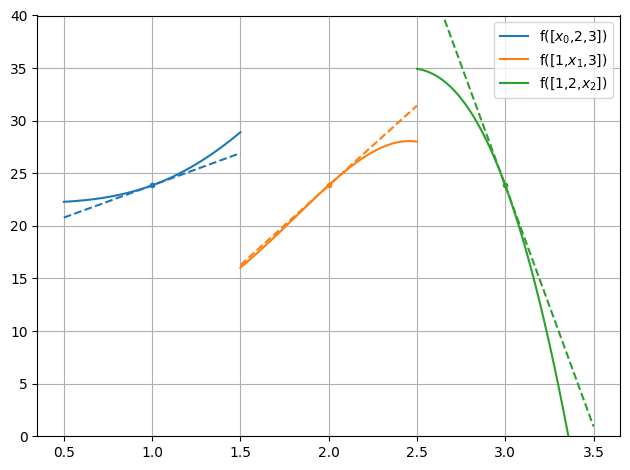

In [3]:
dx_lst = np.linspace(-.5,.5,100)

import matplotlib.pyplot as pltq
from py_wake.utils.plotting import setup_plot

for i in range(3):
    label="f([1,2,3])".replace(str(i+1),f"$x_{i}$")
    c = plt.plot(x[i] + dx_lst, [f(x + np.roll([dx,0,0],i)) for dx in dx_lst], label=label)[0].get_color()
    plt.plot(x[i]+[-.5,.5], f(x) + df(x)[i]*np.array([-.5,.5]), '--', color=c)
    plt.plot(x[i], f(x), '.', color=c)
setup_plot(ylim=[0,40])
plt.legend()

**In PyWake, gradients can be calculated via three methods: finite difference, complex step, and automatic diferentiation (AD) or autograd.**

Below is the theoretical background of each method, followed by a comparison made between the three methods in terms of simulation time required.

### Finite difference `fd`

$\frac{d f(x)}{dx} = \frac{f(x+h) - f(x)}{h}$

Finite difference applied to the example function:


In [4]:
print ("Analytical gradient:", list(df(x)))
h = 1e-6
for i in range(3):
    print (f"Finite difference gradient wrt. x{i}:", (f(x+np.roll([h,0,0],i)) - f(x))/h)

Analytical gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]
Finite difference gradient wrt. x0: 6.129437970514573
Finite difference gradient wrt. x1: 15.164782510623809
Finite difference gradient wrt. x2: -45.839169114714196


In  this example the gradients are accurate to 4th or 5th decimal. The accuracy, however, is highly dependent on the step size, `h`. If the step size is too small the result becomes inaccurate due to nummerical issues. If the step size, on the other hand, becomes too big, then the result represents the gradient of a neighboring point.

This compromize is illusated below:

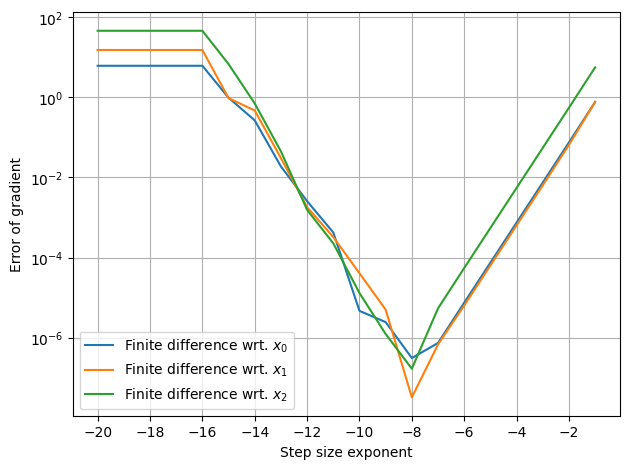

In [5]:
h_lst = 10.**(-np.arange(1,21)) # step sizes [1e-1, ..., 1e-20]

for i in range(3):
    # Plot error compared to analytical gradient, df(x)
    plt.semilogy(np.log10(h_lst), [np.abs(df(x)[i] - (f(x+np.roll([h,0,0],i))-f(x))/h) for h in h_lst], 
                 label=f'Finite difference wrt. $x_{i}$')
plt.xticks(np.arange(-20,-1,2))
setup_plot(ylabel='Error of gradient', xlabel='Step size exponent')

### Complex step

The complex step method is described [here](https://blogs.mathworks.com/cleve/2013/10/14/complex-step-differentiation/).

It utilizes that 

$\frac {d f(x)}{x}= \frac{\operatorname{Im}(f(x+ih))}{h}+O(h^2)$

Applied to the example function, the result is accurate to the 15th decimal.

In [6]:
print ("Analytical gradient:", list(df(x)))
h = 1e-10

for i in range(3):
    print (f"Finite difference gradient wrt. x{i}:", np.imag(f(x+np.roll([h*1j,0,0],i)))/h)

Analytical gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]
Finite difference gradient wrt. x0: 6.129430520583658
Finite difference gradient wrt. x1: 15.164788859062082
Finite difference gradient wrt. x2: -45.83911438119122


Furthermore, the result is much less sensitive to the step size as seen below

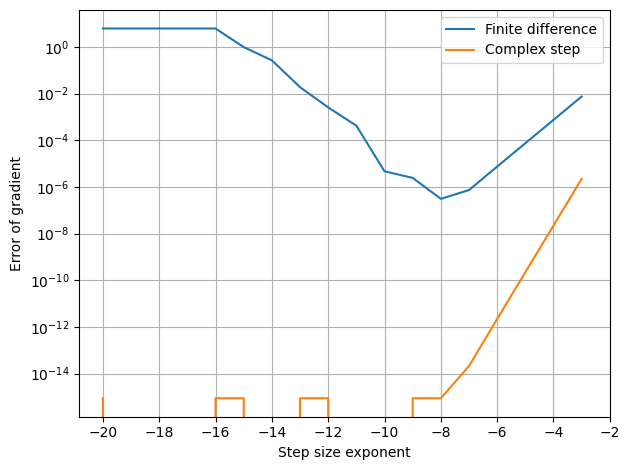

In [7]:
h_lst = 10.**(-np.arange(3,21))

plt.semilogy(np.log10(h_lst), [np.abs(df(x)[0] - (f(x+[h,0,0])-f(x))/h) for h in h_lst], label='Finite difference')
plt.semilogy(np.log10(h_lst), [np.abs(df(x)[0] - np.imag(f(x+[h*1j,0,0]))/h) for h in h_lst], label='Complex step')
plt.xticks(np.arange(-20,-1,2))
setup_plot(ylabel='Error of gradient', xlabel='Step size exponent')

**Common code changes**

The complex step method calls the function with a complex number, i.e. all intermediate functions and routines must support  complex number. A few `numpy` functions have different or undefined behaviour for complex numbers, so often a few changes is required. In PyWake, the module `py_wake.utils.gradients` contains a set of replacement functions that supports complext number, e.g.:

- `abs`
  - For a real value, `x`, `abs(x)` returns the positive value, while for a complex number, it returns the distance from 0 to z, $abs(a+bi)= \sqrt{a^2+b^2}$. 
  - In most cases `abs` should therefore be replaced by `gradients.cabs`, which returns `np.where(x<0,-x,x)`
- `np.hypot(a,b)`
  - `np.hypot` does not support complex numbers
  - replace with `gradients.hypot`, which returns `np.sqrt(a\*\*2+b\*\*2)` if `a` or `b` is complex
- `np.interp(xp,x,y)`
  - replace with `gradients.interp(xp,x,y)`
- `np.logaddexp(x,y)`
  - replace with  `gradients.logaddexp(x,y)` 
  
Furthermore, the imaginary part must be preserved when creating new arrays, i.e.
- `np.array(x,dtype=float)` -> `np.array(x,dtype=(float, np.complex128)[np.iscomplexobj(x)])`


### Automatic Differentiation (Autograd)

[Autograd](https://github.com/HIPS/autograd) is a python package that can automatically differentiate native Python and Numpy code.

Autograd performs a two step automatic differentiation process.

First the normal result is calculated and during this process autograd setups up a calculation tree where each element in the tree holds the associated gradient functions:

<center><img src="../_static/autograd_calculation.svg" width="400"/></center>

For most numpy functions, the associated gradient function is predefined when using `autograd.numpy` instead of `numpy`. You can see the autograd module that defines the gradients of numpy functions [here](https://github.com/HIPS/autograd/blob/master/autograd/numpy/numpy_vjps.py#L32) and the functions used in the example is shown here:

```python
defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),
                        lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
defvjp(anp.add,         lambda ans, x, y : unbroadcast_f(x, lambda g: g),
                        lambda ans, x, y : unbroadcast_f(y, lambda g: g))
defvjp(anp.power,
    lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
    lambda ans, x, y : unbroadcast_f(y, lambda g: g * anp.log(replace_zero(x, 1.)) * x ** y))
defvjp(anp.sin,    lambda ans, x : lambda g: g * anp.cos(x))
```

In the second step, the gradients are calculated by backward propagation

<center><img src="../_static/autograd_differentiation.svg" width="400"/></center>

**Applied to the example function,** `autograd`, **gives the exact results.**

In [8]:
from py_wake import np
from py_wake.utils.gradients import autograd

def f(x):
    return np.sum((2 * x**3) * np.sin(x))

print ("Analytical gradient:", list(df(x)))
print (f"Autograd gradient:", list(autograd(f)(x)))

Analytical gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]
Autograd gradient: [6.129430520583658, 15.164788859062082, -45.83911438119122]


Note, autograd needs its own numpy, `autograd.numpy`, to work. In PyWake, the `autograd` wrapper defined in `py_wake.utils.gradients`, handles this numpy replacement automatically. All it requires is to use `from py_wake import np` instead of the standard `import numpy as np`. This approach also allows an easy switch to single precision for faster simulation.

**Common code changes**

- `x[m] = 0` -> `x = np.where(m,0,x)`
  - Item assignment not supported
  

### Comparison - Scalability of example problem
As seen in the examples, autograd computed the gradients with respect to all input elements in one smart (but slow) function evaluation, while finite difference and complex step required `n + 1` and `n` function evaluations, respectively.

This difference has a high impact on the performance of large scale problems. The plot below shows the time required to compute the gradients as a function of the number of elements in the input vector. In this example the `fd`, `cs` and `autograd` functions from `py_wake.utils.gradients` is utilized.

    from py_wake.utils.gradients import fd, cs, autograd
    from py_wake.tests.check_speed import timeit

    n_lst = np.arange(1,3500,500)
    x_lst = [np.random.random(n) for n in n_lst]

    def get_gradients(method,x):
        return method(f, vector_interdependence=True)(x)

    for method in  [fd, cs, autograd]:
        plt.plot(n_lst, [np.mean(timeit(get_gradients, min_time=.2)(method,x)[1]) for x in x_lst], label=method.__name__)
    setup_plot(title='Time to compute gradients of f(x)', xlabel='Number of elements in x', ylabel='Time [s]')

![image1.png](images/Optimization_gradient_methods.png)

### Gradients in PyWake

As described above, PyWake, contains a module, `py_wake.utils.gradients` which defines the three methods, `fd`, `cs` and `autograd`, as well as a number of helper functions and constructs.

With only a few exceptions, all PyWake models, turbines and sites support the three gradient methods.

Unfortunately, autograd is not working very well with xarray, i.e. the normal xarray `SimulationResult` must be bypassed. This mean that you can compute gradients of the [AEP](#Gradients-of-AEP) or [WS, TI, Power and custom functions](#Gradients-of-WS,-TI,-Power-and-custom-functions) by setting the argument `return_simulationResult=False` when running the wind farm model:  `WindFarmModel(..., return_simulationResult=False)`.

Below we show a simple example with the Hornsrev1 Site and turbines while using the ZongGaussian wake model.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.examples.data.hornsrev1 import Hornsrev1Site, HornsrevV80
from py_wake.utils.gradients import fd, cs, autograd
from py_wake.utils.profiling import timeit
from py_wake.utils.plotting import setup_plot
from py_wake.literature.gaussian_models import Zong_PorteAgel_2020, Bastankhah_PorteAgel_2014
from py_wake.deflection_models.jimenez import JimenezWakeDeflection
from py_wake.turbulence_models.crespo import CrespoHernandez
from py_wake.superposition_models import LinearSum
from py_wake.utils.layouts import rectangle

In [18]:
site = Hornsrev1Site()
wt = HornsrevV80()
wfm = Zong_PorteAgel_2020(site, wt, deflectionModel=JimenezWakeDeflection(), superpositionModel= LinearSum())

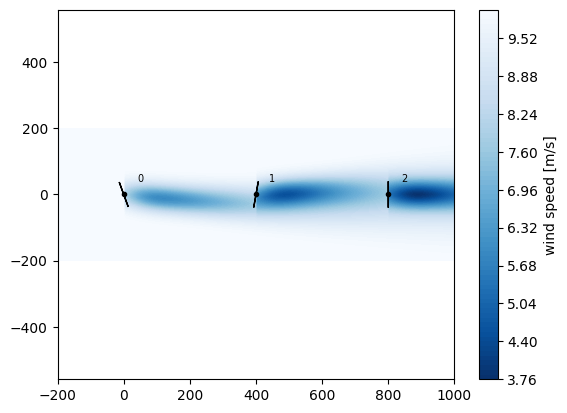

In [19]:
x,y = rectangle(3,3, wt.diameter()*5)
wfm(x,y,wd=[270],ws=10, yaw=[20,-10,0], tilt=0).flow_map().plot_wake_map()

#### Gradients of AEP
The gradients of the AEP can be computed by the `aep_gradients` method of `WindFarmModel` with respect to most of the input arguments. 

In [20]:
for wrt_arg in ['x','y',['x','y'],'h']:
    daep = wfm.aep_gradients(gradient_method=autograd, wrt_arg=wrt_arg)(x=x,y=y, h=[69,70,71], yaw=[20,-10,1], tilt=0)
    print (f"Gradients of AEP wrt. {wrt_arg}", daep)

Gradients of AEP wrt. x [array([-0.00127428, -0.0001223 ,  0.00139658])]
Gradients of AEP wrt. y [array([ 0.00021054, -0.00043951,  0.00022897])]
Gradients of AEP wrt. ['x', 'y'] [array([-0.00127428, -0.0001223 ,  0.00139658]), array([ 0.00021054, -0.00043951,  0.00022897])]
Gradients of AEP wrt. h [array([-2.43899073e-04, -8.14497165e-06,  2.52044045e-04])]


**AEP gradients with respect to (x,y) or (xy)**

When computing gradients with autograd, a significant speed up (40-50%) can be obtained by computing the gradients with respect to both `x` and `y` in one go:

```
wfm.aep_gradients(gradient_method=autograd, wrt_arg=['x','y'])(x,y)
```

Instead of first computing with respect to `x` and then with respect to `y`,

```
wfm.aep_gradients(gradient_method=autograd, wrt_arg='x')(x,y)
wfm.aep_gradients(gradient_method=autograd, wrt_arg='y')(x,y)
```

Functionality to do this automatically under the hood has been implemented in the autograd function.

For finite difference and complex step, the speed is similar.

    from tqdm.notebook import tqdm
    wfm = BastankhahGaussian(site, wt)

    def get_aep(wrt_arg_lst, method):
        return lambda x,y: [wfm.aep_gradients(gradient_method=method, wrt_arg=wrt_arg)(x,y) for wrt_arg in wrt_arg_lst]

    N_lst = np.arange(100,600,100) # number of wt
    D = wt.diameter()
    method=autograd
    res = [(wrt_arg_lst,method, [np.mean(timeit(get_aep(wrt_arg_lst, method=method), min_runs=1)(*rectangle(N,5,D*5))[1]) 
                                 for N in tqdm(N_lst)])
           for wrt_arg_lst in (['x','y'],[['x','y']])]

    ax1,ax2 = plt.subplots(1,2, figsize=(12,4))[1]
    ax1.plot(N_lst, res[0][2], label=f"Wrt. (x), (y), {res[0][1].__name__}")[0].get_color()
    ax1.plot(N_lst, res[1][2], label=f"Wrt. (x, y), {res[1][1].__name__}")
    ax2.plot(N_lst, (np.array(res[0][2]) - res[1][2])/res[0][2]*100)

    setup_plot(ax=ax1, title='Time to compute AEP gradients', ylabel='Time [s]', xlabel='Number of wind turbines')
    setup_plot(ax=ax2, title="Speedup of (xy) compared to (x,y)", ylabel='Speedup [%]', xlabel='Number of wind turbines', ylim=[0,60])

![image2.png](images/Optimization_xy.svg)

**Gradients of WS, TI, Power and custom functions**

The normal `WindFarmModel.__call__` method, which is invoked by `wfm(x,y,...)` returns a xarray Dataset SimulationResult. This step breaks the autograd data flow. We therefore need to specify the argument `return_simulationResult=False`.

The relevant output is:

    WS_eff_ilk, TI_eff_ilk, power_ilk, ct_ilk, *_ = WindFarmModel(..., return_simulationResult=False)

**Below are a two basic examples**

**1) Mean power wrt (x,y) - 2 x 1D inputs, one output**

Compute the gradients of the mean power with respect to both x and y.

Note, there is no need to convert it to a one-merged-input function, as the autograd method in PyWake does this under the hood

In [ ]:
def mean_power(x,y):
    power_ilk = wfm(x=x, y=y, yaw=0, tilt=0, return_simulationResult=False)[2] # index 2 = power_ilk
    return power_ilk.mean()

mean_power_gradients_function = autograd(mean_power,vector_interdependence=True, argnum=[0,1])
d_aep = mean_power_gradients_function(x, y)

print ('AEP Gradients:',d_aep)
print (np.shape(d_aep))

**2) Power per wind speed wrt. x - 1D input, 1D output**

Compute the gradients of the power per wind speed (i.e. power meaned over wind turbine and direction) with respect to x.

In [ ]:
def ws_power(x):
    power_ilk = wfm(x=x, y=y, yaw=0, tilt=0, return_simulationResult=False)[2] # index 2 = power_ilk
    return power_ilk.mean((0,1)) # mean power pr wind speed

ws_power_gradients_function = autograd(ws_power,vector_interdependence=True)
np.shape(ws_power_gradients_function(x))

**Manual gradient functions for autograd**

Autograd can be supplemented with custom gradient functions, that bypass the automatic differentiation process and returns the gradients directly.
This is usefull for functions that cannot be analytically differentiated by autograd, e.g. interpolation functions. Some commonly used functions have been implemented in `py_wake.utils.gradients`, e.g.

- trapz (np.trapz)
- interp (np.interp)
- PchipInterpolator (scipy.PchipInterpolator)
- UnivariateSpline (scipy.UnivariateSpline)


Specifying the gradient functions and ensuring that they return the gradients in the right dimensions is, however, not trivial. 

It was expected that the computational time could be reduced by specifying maually-implemented gradient functions of some time-critical functions. An example is shown below, where functions to calculate the gradients of `calc_deficit` of the `BastankhahGaussianDeficit` with respect to all inputs are implemented.

In [ ]:
from py_wake.deficit_models.gaussian import BastankhahGaussianDeficit
from py_wake.utils.gradients import set_vjp
from py_wake.utils.model_utils import method_args
import warnings

class BastankhahGaussianDeficitGradients(BastankhahGaussianDeficit):
    def __init__(self, k=0.0324555, ceps=.2, use_effective_ws=False):
        BastankhahGaussianDeficit.__init__(self, k=k, ceps=ceps, use_effective_ws=use_effective_ws)
        self._additional_args = method_args(self.calc_deficit)
        self.use_effective_ws = use_effective_ws
        self.calc_deficit = set_vjp([self.get_ddeficit_dx(i) for i in range(6)])(self.calc_deficit)

    @property
    def additional_args(self):
        return BastankhahGaussianDeficit.additional_args.fget(self) | self._additional_args

    def calc_deficit(self, WS_ilk, WS_eff_ilk, D_src_il, dw_ijlk, cw_ijlk, ct_ilk, **kwargs):
        return BastankhahGaussianDeficit.calc_deficit(self, D_src_il, dw_ijlk, cw_ijlk, ct_ilk,
                                                      WS_ilk=WS_ilk, WS_eff_ilk=WS_eff_ilk, **kwargs)

    def get_ddeficit_dx(self, argnum):
        import numpy as np  # override autograd.numpy
        from numpy import newaxis as na

        def ddeficit_dx(ans, WS_ilk, WS_eff_ilk, D_src_il, dw_ijlk, cw_ijlk, ct_ilk, **kwargs):
            _, _, _, K = np.max([dw_ijlk.shape, cw_ijlk.shape, WS_ilk[:, na].shape], 0)
            eps = 0
            WS_ref_ilk = (WS_ilk, WS_eff_ilk)[self.use_effective_ws]
            ky_ilk = self.k_ilk(**kwargs)
            beta_ilk = 0.5 * (1 + 1 / np.sqrt(1 - ct_ilk))
            sigma_ijlk = ky_ilk[:, na] * dw_ijlk * (dw_ijlk > eps) + \
                .2 * D_src_il[:, na, :, na] * np.sqrt(beta_ilk[:, na])
            a_ijlk = ct_ilk[:, na] / (8. * (sigma_ijlk / D_src_il[:, na, :, na])**2)
            sqrt_ijlk = np.sqrt(np.maximum(0., 1 - a_ijlk))
            layout_factor_ijlk = WS_ref_ilk[:, na] * (dw_ijlk > eps) * np.exp(-0.5 * (cw_ijlk / sigma_ijlk)**2)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                if argnum == 0:
                    dWS = ans / WS_ref_ilk[:, na]
                elif argnum == 1:
                    dWS_eff = ans / WS_eff_ilk[:, na]
                elif argnum == 2:
                    dD_sqrt_pos = (a_ijlk * (1 / D_src_il[:, na, :, na] - 0.2 * np.sqrt(beta_ilk[:, na]) / sigma_ijlk) / sqrt_ijlk +
                                   (1 - sqrt_ijlk) * (cw_ijlk**2 / sigma_ijlk**3) * .2 * np.sqrt(beta_ilk[:, na])) * layout_factor_ijlk
                    dD_sqrt_neg = (cw_ijlk**2 / sigma_ijlk**3) * .2 * np.sqrt(beta_ilk[:, na]) * layout_factor_ijlk
                    dD = np.where(sqrt_ijlk == 0, dD_sqrt_neg, dD_sqrt_pos)
                elif argnum == 3:
                    ddw_sqrt_pos = (-a_ijlk / sqrt_ijlk + (1 - sqrt_ijlk) * (cw_ijlk / sigma_ijlk)**2) * \
                        ky_ilk[:, na] / sigma_ijlk * layout_factor_ijlk
                    ddw_sqrt_neg = (cw_ijlk / sigma_ijlk)**2 * ky_ilk[:, na] / sigma_ijlk * layout_factor_ijlk
                    ddw = np.where(sqrt_ijlk == 0, ddw_sqrt_neg, ddw_sqrt_pos)
                elif argnum == 4:
                    dcw = ans * (- cw_ijlk / (sigma_ijlk**2))
                elif argnum == 5:
                    dsigmadct_ilk = 0.2 * D_src_il[:, :, na] / (8 * np.sqrt(beta_ilk * (1 - ct_ilk)**3))
                    dct_sqrt_pos = (a_ijlk * (1 / (2 * ct_ilk[:, na]) - dsigmadct_ilk[:, na] / sigma_ijlk) / sqrt_ijlk +
                                    (1 - sqrt_ijlk) * (cw_ijlk**2 / sigma_ijlk**3) * dsigmadct_ilk[:, na]) * layout_factor_ijlk
                    dct_sqrt_neg = (cw_ijlk**2 / sigma_ijlk**3) * dsigmadct_ilk[:, na] * layout_factor_ijlk
                    dct = np.where(sqrt_ijlk == 0, dct_sqrt_neg, dct_sqrt_pos)

            def dWS_ilk(g):
                r = g * dWS[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                j = np.r_[np.where(g)[1], 0][0]
                ilk = (slice(None), j)
                return r[ilk]

            def dWS_eff_ilk(g):
                r = g * dWS_eff[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                j = np.r_[np.where(g)[1], 0][0]
                ilk = (slice(None), j)
                return r[ilk]

            def dD_src_il(g):
                r = g * dD[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                j = np.r_[np.where(g)[1], 0][0]
                k = np.r_[np.where(g)[3], 0][0]
                il = (slice(None), j, slice(None), k)
                return r[il]

            def ddw_ijlk(g):
                r = g * ddw[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                if dw_ijlk.shape[-1] == 1 and K > 1:
                    # If dw_ijlk is independent of ws, i.e. last dimension is 1 while len(ws)>1
                    # then we need to sum the gradients wrt. wind speeds
                    r = r.sum(3)[:, :, :, na]
                return r[:, :, :, 0:dw_ijlk.shape[3]]

            def dcw_ijlk(g):
                r = g * dcw[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                if cw_ijlk.shape[-1] == 1 and K > 1:
                    # If cw_ijlk is independent of ws, i.e. last dimension is 1 while len(ws)>1
                    # then we need to sum the gradients wrt. wind speeds
                    r = r.sum(3)[:, :, :, na]
                return r[:, :, :, 0:cw_ijlk.shape[3]]

            def dct_ilk(g):
                r = g * dct[:g.shape[0], :g.shape[1], :g.shape[2], :g.shape[3]]
                j = np.r_[np.where(g)[1], 0][0]
                ilk = (slice(None), j)
                return r[ilk]

            return [dWS_ilk, dWS_eff_ilk, dD_src_il, ddw_ijlk, dcw_ijlk, dct_ilk][argnum]
        return ddeficit_dx


In this example, however, the model with manual gradient functions performs worse than the original where autograd derives the gradient functions automatically.

In [ ]:
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.examples.data.hornsrev1 import wt16_x, wt16_y

wfm_autograd = PropagateDownwind(site, wt, BastankhahGaussianDeficit())
wfm_manual = PropagateDownwind(site, wt, BastankhahGaussianDeficitGradients())

ws = np.arange(4,26)
x,y = wt16_x, wt16_y
ref, t_auto = timeit(lambda: wfm_autograd.aep_gradients(gradient_method=autograd, wrt_arg=['x','y'])(x, y, ws=ws))()
res, t_manual = timeit(lambda: wfm_manual.aep_gradients(gradient_method=autograd, wrt_arg=['x','y'])(x, y, ws=ws))()
np.testing.assert_array_almost_equal(res, ref, 4)

print ("Time, automatic gradients", np.mean(t_auto))
print ("Time, manual gradients", np.mean(t_manual))

### Comparison - Scalability of AEP gradients

As seen in the previous comparison of scalability example, the autograd scales much better with the number of input variables than finite difference and complex step. 

When considering large wind farms, autograd is convincingly outperforming both finite difference and complex step, but it also requires much more memory.

**The following plots are based on simulation performance on the Sophia HPC cluster.**

In [ ]:
data = {
    "fd":((10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150,200, 250, 300),
          [0.89, 3.06, 7.13, 14.77, 24.46, 41.06, 64.46, 105.98, 140.76, 171.53, 590.46, 1501.62, 2957.65, 4904.31],
          [14.1, 31.9, 58.8, 92.2, 135.3, 184.2, 240.6, 303.1, 373.6, 450.7, 946.5, 1620.8, 2470.1, 3500.5]),   
"cs":((10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250),
      [1.18, 4.9, 12.44, 25.58, 44.56, 72.82, 115.46, 171.42, 245.15, 312.9, 960.64, 2883.04, 5345.27],
      [22.3, 55.7, 107.6, 171.0, 244.1, 338.7, 442.7, 566.9, 690.9, 839.0, 1787.4, 3088.9, 4742.4]),
"autograd":((10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500),
            [0.32, 0.78, 1.52, 2.49, 3.75, 5.33, 7.14, 9.12, 11.43, 14.02, 32.35, 53.73, 84.94, 130.53, 169.34, 229.62, 270.19, 342.01],
            [26.7, 92.9, 196.4, 340.0, 525.9, 749.6, 1011.1, 1312.2, 1656.0, 2039.7, 4555.0, 8066.8, 12569.9, 18072.6, 24568.2, 32069.6, 40558.9, 50036.6]),
       }
ax1,ax2 = plt.subplots(1,2, figsize=(12,4))[1]
for k,(n,t,m) in data.items():
    ax1.plot(n,np.array(t)/60, label=k)
    ax2.plot(n,np.array(m)/1024, label=k)
setup_plot(ax1, xlabel='Number of wind turbines', ylabel='Time [min]')
setup_plot(ax2, xlabel='Number of wind turbines', ylabel='Memory usage [GB]')
plt.savefig('test.png', dpi=600)
import os
os.getcwd()

## Chunkify and Parallelization

PyWake makes it easy to chunkify the run wind farm simulations see also section [Run Wind Farm Simulation](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/RunWindFarmSimulation.html).

This construct is also available and usefull when computing gradients to reduce the memory usage and/or speed up the computation by parallel execution.

The arguments, `wd_chunks`, `ws_chunks` and `n_cpu` are available in the `WindFarmModel.aep(...)`, `WindFarmModel(...)` and `WindFarmModel.aep_gradients(...)` methods.


In [ ]:
from py_wake import np
import matplotlib.pyplot as plt

from py_wake.literature.noj import Jensen_1983
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, HornsrevV80, wt_x, wt_y, wt16_x, wt16_y
from py_wake.utils.profiling import timeit
import multiprocessing
from py_wake.utils.gradients import autograd, fd
from py_wake.utils.plotting import setup_plot

In [ ]:
site = Hornsrev1Site()
wt = HornsrevV80()
wfm = Jensen_1983(site, wt)
x,y = wt16_x,wt16_y

### AEP

Computing AEP in parallel chunks.

Setting `n_cpu=None`, splits the problem into `N` wind direction chunks which is computed in parallel on `N` CPUs, where `N` is the number of CPUs on the machine. Alternatively, a number can be specified.

In [ ]:
print('Total AEP: %f GWh'%wfm.aep(x, y, n_cpu=None))

### WS, TI, Power and custom functions

Computing mean power in parallel chunks

In [ ]:
def mean_power(x,y):
    power_ilk = wfm(x=x, y=y, n_cpu=None, return_simulationResult=False)[2] # index 2 = power_ilk
    return power_ilk.mean()

print('Mean Power: %f MW'%(mean_power(x,y)/1e6))

### AEP gradients

In the previous section, [Gradients of AEP](#Gradients-of-AEP), the `aep_gradients` method was used like this:

```python
gradient_function = wfm.aep_gradients(fd, wrt_arg='xy')
daep = gradient_function(x=x,y=y)
```

When dealing with chunkification and/or parallelization, the `aep_gradients` must be used in a slightly different way:

In [ ]:
daep = wfm.aep_gradients(autograd, wrt_arg=['x','y'], n_cpu=None, x=x, y=y)

Note, in this case, the arguments normally passed to `wfm.aep` (here `x` and `y`) are passed directly to the `wfm.aep_gradients` method as keyword arguments and the method returns the gradients results instead of a function.

**The plot below shows the time it takes to compute the gradients of AEP with respect to x and y plotted as a function of number of wind turbines and CPUs**

    from py_wake.utils import layouts 
    from py_wake.utils.profiling import timeit
    from tqdm.notebook import tqdm

    n_lst = np.arange(100,600,100)

    def run(n, n_cpu):
        x,y = layouts.rectangle(n,20,5*wt.diameter())
        return (n, n_cpu, np.mean(timeit(wfm.aep_gradients)(autograd, ['x','y'], n_cpu=n_cpu, x=x,y=y)[1]))

    res = {f'{n_cpu} CPUs': np.array([run(n, n_cpu=n_cpu) for n in tqdm(n_lst)]) for n_cpu in [1, 4, 16, 32]}

    ax1,ax2 = plt.subplots(1,2, figsize=(12,4))[1]
    for k,v in res.items():
        n,n_cpu,t = v.T
        ax1.plot(n, t, label=k)
        ax2.plot(n, res['1 CPUs'][:,2]/n_cpu/t*100, label=k)
    setup_plot(ax=ax1,xlabel='No. wind turbines',ylabel='Time [s]')
    setup_plot(ax=ax2,xlabel='No. wind turbines',ylabel='CPU utilization [%]')
    plt.savefig('images/Optimization_time_cpuwt.svg')

**Result precomputed on the Sophia HPC cluster on a node with 32 CPUs.**



**Parallelization of gradients of WS, TI, Power and custom functions is not implemented yet**

## Precision

**As default, PyWake simulates in double precision, i.e. 64 bit floating point values.**

In some cases, however, single precision, i.e. 32 bit floating point values, may be sufficient and faster. 

In PyWake, the `Numpy32` context manager makes switching to single precition is very easy:

In [ ]:
from py_wake.utils.numpy_utils import Numpy32

with Numpy32():
    print (np.array([1.,2,3]).dtype)
    print (np.sin([1,2,3]).dtype)

In [ ]:
# same with out context manager
print (np.array([1.,2,3]).dtype)
print (np.sin([1,2,3]).dtype)

    from py_wake.utils import layouts 
    from py_wake.utils.profiling import timeit
    from tqdm.notebook import tqdm

    n_lst = np.arange(50,550,50)
    xy_lst = [layouts.rectangle(n,20,5*wt.diameter()) for n in n_lst]

    t_lst_64 = [np.mean(timeit(wfm.aep, min_runs=10)(x,y)[1]) for x,y in tqdm(xy_lst)]

    with Numpy32():
        t_lst_32 = [np.mean(timeit(wfm.aep, min_runs=10)(x,y)[1]) for x,y in tqdm(xy_lst)]

    ax1, ax2 = plt.subplots(1,2,figsize=(12,4))[1]
    ax1.plot(n_lst, t_lst_64, label='Double precision')
    ax1.plot(n_lst, t_lst_32, label='Single precision')
    setup_plot(ax=ax1, ylabel='Time [s]',xlabel='No. wind turbines')
    ax2.plot(n_lst, np.array(t_lst_64) / t_lst_32)
    setup_plot(ax=ax2, ylabel='Speedup',xlabel='No. wind turbines')
    plt.savefig('images/Optimization_precision.svg')

**Result precomputed on the Sophia HPC cluster.**

![image1.png](images/Optimization_precision.svg)